# Advanced Skew-T Calculations and Plotting

This notebook demonstrates calculating a number of common sounding parameters and plotting some of them on a skew-T diagram.

### Import Packages

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units, pandas_dataframe_to_unit_arrays
import numpy as np
from siphon.simplewebservice.wyoming import WyomingUpperAir

### Get Data

In [4]:
# Set date that you want
# Data goes back to the 1970's
date = datetime(2020, 5, 4, 12)

# Set station ID, there are different stations back in the day
# Current station IDs found at http://weather.rap.ucar.edu/upper
station = 'DTX'

# Use Siphon module to grab data from remote server
df = WyomingUpperAir.request_data(date, station)

In [5]:
# Create dictionary of unit arrays
data = pandas_dataframe_to_unit_arrays(df)

# Isolate united pressure array from dictionary
p = data['pressure']

# Setting a subset to only use the data needed
idx = p.m > 90

# Isolate united arrays and subset from dictionary
p = p[idx]
T = data['temperature'][idx]
Td = data['dewpoint'][idx]
u = data['u_wind'][idx]
v = data['v_wind'][idx]

### Calculations of Sounding Parameters

Once we have our data, we can calculate any of the skew-T variables we desire, such as LCL using the functions available in MetPy (https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html#soundings).

In [6]:
# Calculate LCL pressure and temperature
# Note: since lcl function returns two values, we can have
# two variables to the left of the equal sign

lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
print(f'LCL: {lcl_pressure:.2f}')

LCL: 923.76 hectopascal


In [7]:
# Calculate full surface parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

# Calculate the CAPE and CIN of the profile
cape, cin = mpcalc.cape_cin(p, T, Td, prof)

print(f'CAPE: {cape:.2f}')
print(f'CIN: {cin:.2f}')

CAPE: 3.97 joule / kilogram
CIN: 0.00 joule / kilogram


In [8]:
# Find the index value of 500 hPa in dataframe
ip500 = list(p.m).index(500)

# Compute LI and print result
LI = T[ip500] - prof[ip500]
print(f'LI: {LI.m:.02f} C')

LI: 13.29 C


### Plot Skew-T with Parcel Path

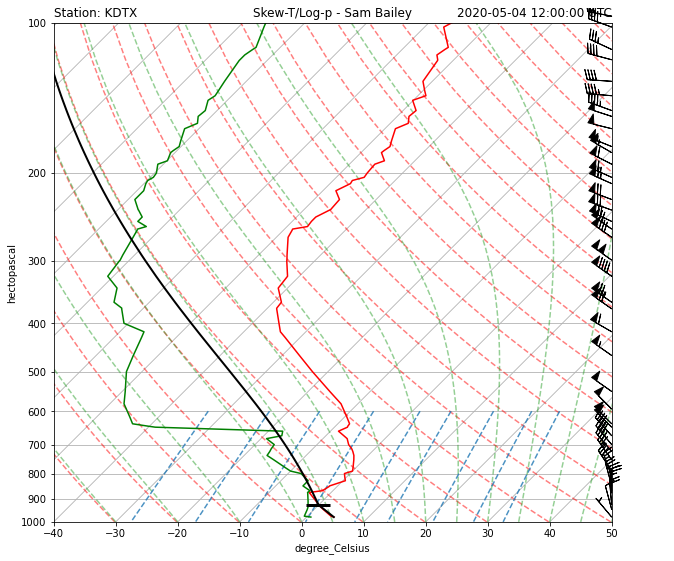

In [9]:
fig = plt.figure(figsize=(10, 10))

skew = SkewT(fig,  rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')

# Plot barbs skipping to every other barb
skew.plot_barbs(p[::2], u[::2], v[::2], y_clip_radius=0.03)

# Set sensible axis limits
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 50)

# Plot the skew-T parcel temperature profile
skew.plot(p, prof, 'k', linewidth=2)

# Plot a line marker at the LCL level
skew.plot(lcl_pressure, lcl_temperature, '_', color='black', markersize=24, 
          markeredgewidth=3, markerfacecolor='black')

# Add the relevant special lines
skew.plot_dry_adiabats(t0=np.arange(233,555,10)*units.K)
skew.plot_moist_adiabats(colors='tab:green')
skew.plot_mixing_lines(colors='tab:blue')

# Plot some titles
plt.title(f'Station: K{station}', loc='left')
plt.title('Skew-T/Log-p - Sam Bailey', loc='center')
plt.title(f'{date} UTC', loc='right')

# Show the plot
plt.savefig('HW10-1.png', bbox_inches='tight', dpi=150)
#plt.show()